In [1]:
import sparknlp
from pyspark.ml import PipelineModel, Pipeline
import sparknlp.annotator as sa
import sparknlp.base as sb
import sparknlp
from sparknlp import Finisher

In [2]:
import sys
sys.path.insert(0, '../')
from util import util_data_access

In [3]:
# download data
util_data_access.download_file('newssniffer-nytimes.db.gz', 'edit-pathways/dbs/newssniffer-nytimes.db.gz')
! gunzip newssniffer-nytimes.db.gz

gzip: newssniffer-nytimes.db already exists; do you wish to overwrite (y or n)? ^C


In [ ]:
# util_data_access.download_file('glove-100d-loc.tar.gz', 'spark-nlp/glove-100d-loc.tar.gz')
# ! tar -xzvf glove-100d-loc.tar.gz 

# Load Spark

In [2]:
from pyspark.sql import SparkSession
# spark = sparknlp.start()

spark = (
    SparkSession.builder
      .config("spark.executor.instances", "30")
      .config("spark.driver.memory", "20g")
      .config("spark.executor.memory", "20g")
      .config("spark.executor.cores", "5")
      .config("spark.kryoserializer.buffer.max", "2000M")
      .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.7.5")
      .getOrCreate()
)

In [3]:
spark

# Load Our Own Data

In [243]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import pyspark.sql.functions as F
# import unidecode

# conn = sqlite3.connect('../data/diffengine-diffs/db/newssniffer-nytimes.db')
with sqlite3.connect('newssniffer-nytimes.db') as conn:

    # df = pd.read_sql('''
    #      SELECT * from entryversion 
    #      WHERE entry_id IN (SELECT distinct entry_id FROM entryversion LIMIT 2)
    #  ''', con=conn)

    df = pd.read_sql('''
         SELECT * from entryversion 
         WHERE entry_id IN (1951413, 1952324, 1969148, 1451793, 1938021)
     ''', con=conn)

    df = df.assign(summary=lambda df: df['summary'].str.replace('</p><p>', ' '))

In [244]:
sdf = spark.createDataFrame(df)

# With Sentences

In [245]:
from pyspark.ml.feature import Normalizer, SQLTransformer
from pyspark.ml.feature import BucketedRandomProjectionLSH
from scipy.spatial import distance
from pyspark.sql.types import FloatType
from scipy.spatial import distance

In [7]:
documenter = (
    sb.DocumentAssembler()
        .setInputCol("summary")
        .setOutputCol("document")
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)

word_embeddings = (
    sa.BertEmbeddings
        .load('s3://aspangher/spark-nlp/small_bert_L4_128_en_2.6.0_2.4')
        .setInputCols(["sentences", "token"])
        .setOutputCol("embeddings")
        .setMaxSentenceLength(512)
        .setBatchSize(100)
)

tok_finisher = (
    Finisher()
    .setInputCols(["token"])
    .setIncludeMetadata(True)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [168]:
zip_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT CAST(entry_id AS int) as entry_id,
                CAST(version AS int) as version, 
                ARRAYS_ZIP(finished_token, finished_token_metadata, embeddings_vectors) AS zipped_tokens
         FROM __THIS__
    """)
)

explode_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(zipped_tokens) AS (word_idx, zipped_token)
         FROM __THIS__
    """)
)

rename_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, 
                 version,
                 CAST(zipped_token.finished_token_metadata._2 AS int) AS sent_idx,
                 COUNT(1) OVER(PARTITION BY entry_id, version, zipped_token.finished_token_metadata._2) as num_words,
                 CAST(word_idx AS int) word_idx,
                 zipped_token.finished_token AS token,
                 zipped_token.embeddings_vectors as word_embedding
         FROM __THIS__
    """)
) 

vector_normalizer = (
    Normalizer(
        inputCol="word_embedding", 
        outputCol="norm_word_embedding", 
        p=2.0
    )
)
similarty_checker = (
    BucketedRandomProjectionLSH(
        inputCol="norm_word_embedding", 
        outputCol="hashes", 
        bucketLength=6.0, 
        numHashTables=6
    )
)

def cosine_distance(x, y):
    return float(distance.cosine(x, y))
spark.udf.register("cosine_distance", cosine_distance, "float")

inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id                                                    AS entry_id, 
                 word_emb.version                                                    AS version_x,
                 word_emb_2.version                                                  AS version_y,
                 word_emb.sent_idx                                                   AS sent_idx_x,
                 word_emb_2.sent_idx                                                 AS sent_idx_y,
                 word_emb.num_words                                                  AS num_words_x,
                 word_emb.word_idx                                                   AS word_idx_x,
                 word_emb_2.word_idx                                                 AS word_idx_y,
                 word_emb.token                                                      AS token_x,
                 word_emb_2.token                                                    AS token_y,
                 cosine_distance(word_emb.word_embedding, word_emb_2.word_embedding) AS cosine_distance
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version + 1 = word_emb_2.version
    """)
)

In [169]:
get_word_pair_min_distance = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_x,
                MIN(num_words) as num_words_total_list,
                MIN(distance) as min_word_distance
        FROM __THIS__ 
        GROUP BY entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_x
      """)
)

get_sentence_min_distance = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                (sum_min_word_distance + 1 * ( num_words_total - num_matched_words )) / num_matched_words AS avg_sentence_distance
        FROM (SELECT  entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y, 
        SUM(min_word_distance) AS sum_min_word_distance,
        COUNT(1) AS num_matched_words,
        MIN(num_words_total_list) AS num_words_total
        FROM __THIS__
        GROUP BY entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y
          )
      """)
)

get_min_sentence_rn = (
    SQLTransformer()
     .setStatement("""
         SELECT * FROM (
             SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_x
                                      ORDER BY avg_sentence_distance ASC
         ) AS rn FROM __THIS__)
         where rn = 1
    """)
)

In [171]:
similarity_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    word_embeddings,
    embeddings_finisher,
    tok_finisher,
    # 
    zip_tok,
    explode_tok,
    rename_tok,
    vector_normalizer,
    similarty_checker
    # 
#     inner_join,
    # get_max_word_min, ### too slow!!
    
  ]
)

In [172]:
# word_emb_sdf = similarity_pipeline.fit(sdf).transform(sdf)

In [246]:
## Approximate Join
similarity_model = similarity_pipeline.fit(sdf)
sim_sdf = similarity_model.transform(sdf)
joined_df = (
    similarity_model
    .stages[10]
    .approxSimilarityJoin(sim_sdf, sim_sdf, .5, distCol="distance")
    .where((F.col("datasetA.entry_id") == F.col("datasetB.entry_id")) & (F.col("datasetA.version") + 1 == F.col("datasetB.version")))
    .select(
         F.col("datasetA.entry_id").alias("entry_id"),
         F.col("datasetA.version").alias("version_x"),
         F.col("datasetB.version").alias("version_y"),
         F.col("datasetA.sent_idx").alias("sent_idx_x"),
         F.col("datasetB.sent_idx").alias("sent_idx_y"),        
         F.col("datasetA.word_idx").alias("word_idx_x"),
         F.col("datasetB.word_idx").alias("word_idx_y"),
         F.col("datasetA.num_words").alias("num_words"),
         F.col("datasetA.token").alias("token_x"),
         F.col("datasetB.token").alias("token_y"),
         F.col("distance")
    )
)

## get top sentences
top_sentence_pipeline = sb.PipelineModel(stages=[
    get_word_pair_min_distance,
    get_sentence_min_distance,
    get_max_word_rn,
])

In [247]:
min_sent_df = top_sentence_pipeline.transform(joined_df)

In [248]:
# min_words_dfp = min_words_df.toPandas()

In [250]:
min_sent_dfp = min_sent_df.toPandas()

In [253]:
min_sent_dfp = min_sent_dfp.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])

# Get Sentences for Inspection

In [339]:
normer = (
    sa.DocumentNormalizer()
    .setInputCols(["document"])
    .setOutputCol("normed_document")
#     .setPatterns(["[^\w\d\s.,\"\']"])
#     .setPolicy('pretty_all')
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["normed_document"])
        .setOutputCol("sentences")            
)

sentencer_dl = (
    sa.SentenceDetectorDLModel
        .load('s3://aspangher/spark-nlp/sentence_detector_dl_en')
        .setInputCols(["normed_document"])
        .setOutputCol("sentences")            
)

sent_finisher = (
    Finisher()
    .setInputCols(["sentences"])
)

explode_sent = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(finished_sentences) AS (sent_idx, sentence)
         FROM __THIS__
    """)
)

sentence_splitter_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    normer,
    sentencer,
    sent_finisher,
    explode_sent
])

In [296]:
import re

In [340]:
sent_dfp_nondl = sentence_splitter_pipeline.fit(sdf).transform(sdf).toPandas()

In [334]:
sent_dfp_dl = sentence_splitter_pipeline.fit(sdf).transform(sdf).toPandas()

In [331]:
sent_dfp_dl.shape

(9988, 4)

In [373]:
sent_dfp_nondl.head()['sentence'].iloc[1]

'The storm’s eye wall was on track to hit the Lower Keys between 7 and 8 a.m., the National Hurricane Center said in its 5 a.m.'

In [375]:
sent_dfp_nondl.head()['sentence'].iloc[2]

'Eastern advisory.'

In [356]:
(sent_dfp_dl
 .loc[lambda df: df['entry_id'] == 1451793]
 .loc[lambda df: df['version'] == 0].shape
)

(76, 4)

In [349]:
len(unp.split_sents(df.loc[0]['summary']))

84

In [365]:
num_sents = []
for entry_id, version, text in tqdm(df[['entry_id', 'version', 'summary']].itertuples(index=False), total=len(df)):
    num_sents.append({
        'entry_id': entry_id,
        'version': version,
        'num_sents': len(unp.split_sents(text))
    })

  0%|          | 0/119 [00:00<?, ?it/s]

In [372]:
pd.concat([
    sent_dfp_dl.groupby(['entry_id', 'version']).apply(lambda df: len(df)).to_frame('dl'),
    sent_dfp_nondl.groupby(['entry_id', 'version']).apply(lambda df: len(df)).to_frame('nondl'),
    pd.DataFrame(num_sents).set_index(['entry_id', 'version'])['num_sents'].to_frame('spacy')
], axis=1).head()

dl  nondl  spacy
entry_id version                  
1451793  0        76     83     84
         1        76     83     84
         2        75     83     84
         3        74     82     85
         4        86    100    103

In [199]:
(sent_dfp
 .loc[lambda df: df['entry_id'] == 547989]
 .loc[lambda df: df['version'].isin([1, 2])]
 .loc[lambda df: df['sent_idx'] == 1]
)

,entry_id,version,sent_idx,sentence
153,547989,1,1,Overseas weapons sales by the United States to...
173,547989,2,1,Overseas weapons sales by the United States to...


# Compare Sentences

In [214]:
comp_sents = (min_sent_dfp
 .loc[lambda df: df['entry_id'] == 547989]
 .loc[lambda df: df['version_x'] == 0]
 .loc[lambda df: df['version_y'] == 1]
 .merge(
    sent_dfp, 
    left_on=['entry_id', 'version_x', 'sent_idx_x'],
    right_on=['entry_id', 'version', 'sent_idx']
 ).drop(['rn', 'version', 'sent_idx',], axis=1)
 .merge(
    sent_dfp, 
    left_on=['entry_id', 'version_y', 'sent_idx_y'],
    right_on=['entry_id', 'version', 'sent_idx']
 )
 .drop(['version', 'sent_idx',], axis=1)
)

In [221]:
import sys
sys.path.append('..')
## download spacy model 
# download data
from util import util_data_access
util_data_access.download_file('en_core_web_lg.tar.gz', 'edit-pathways/spacy/en_core_web_lg.tar.gz')
! tar -xf en_core_web_lg.tar.gz
! mv en_core_web_lg-2.3.1 en_core_web_lg
import util.util_newssniffer_parsing as unp

In [240]:
html = [
    '<table>',
    '<tr><th>Sentence idx</th><th>Old Version</th><th>New Version</th><th>Distance</th></tr>',
]
for s_idx, s1, s2, d in comp_sents[['sentence_x', 'sentence_y', 'avg_sentence_distance']].itertuples():
    one_row = '<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>'
    w1, w2 = unp.get_words(s1), unp.get_words(s2)
    hs1, hs2 = unp.html_compare_sentences(*unp.get_list_diff(w1, w2))
    html.append(one_row % (s_idx, hs1, hs2, d))
    
html_output = ''.join(html).replace('$', r'\$')

In [241]:
from IPython.display import display, HTML

In [242]:
display(HTML(html_output))

Sentence idx,Old Version,New Version,Distance
0,"WASHINGTON — Weapons sales by the United States tripled in 2011 to a record high , driven by major arms sales to Persian Gulf allies concerned about Iran ’s regional ambitions , according to a new study for Congress .","WASHINGTON — Weapons sales by the United States tripled in 2011 to a record high , driven by major arms sales to Persian Gulf allies concerned about Iran ’s regional ambitions , according to a new study for Congress .",0.0
1,"Overseas weapons sales by the United States totaled \$ 66.3 billion last year , or nearly 78 percent of the global arms market valued at \$ 85.3 billion in 2011 .","Overseas weapons sales by the United States totaled \$ 66.3 billion last year , or nearly 78 percent of the global arms market , valued at \$ 85.3 billion in 2011 .",0.08589556865218667
2,"Russia was a distant second , with \$ 4.8 billion in deals .","Russia was a distant second , with \$ 4.8 billion in deals .",0.0
3,"The American weapons sales total was an “ extraordinary increase ” over the \$ 21.4 billion in deals for 2010 , the study found , and was the largest single - year sales total in the history of United States arms exports .","The American weapons sales total was an “ extraordinary increase ” over the \$ 21.4 billion in deals for 2010 , the study found , and was the largest single - year sales total in the history of United States arms exports .",0.0
4,"The previous high was in fiscal year 2009 , when American weapons sales overseas totaled nearly \$ 31 billion .","The previous high was in fiscal year 2009 , when American weapons sales overseas totaled nearly \$ 31 billion .",0.0
5,A worldwide economic decline had suppressed arms sales over recent years .,A worldwide economic decline had suppressed arms sales over recent years .,0.0
6,"But increasing tensions with Iran drove a set of Persian Gulf nations — Saudi Arabia , the United Arab Emirates and Oman — to purchase American weapons at record levels .","But increasing tensions with Iran drove a set of Persian Gulf nations — Saudi Arabia , the United Arab Emirates and Oman — to purchase American weapons at record levels .",0.0
7,"These gulf states do not share a border with Iran , and their arms purchases focused on expensive warplanes and complex missile defense systems .","These Gulf states do not share a border with Iran , and their arms purchases focused on expensive warplanes and complex missile defense systems .",0.0
8,"The report was prepared by the nonpartisan Congressional Research Service , a division of the Library of Congress .","The report was prepared by the nonpartisan Congressional Research Service , a division of the Library of Congress .",0.0
9,"The annual study , written by Richard F. Grimmett and Paul K. Kerr and delivered to Congress on Friday , is considered the most detailed collection of unclassified arms sales data available to the public .","The annual study , written by Richard F. Grimmett and Paul K. Kerr and delivered to Congress on Friday , is considered the most detailed collection of unclassified arms sales data available to the public .",0.0


In [58]:
get_word_pair_min_distance.transform(joined_df).show()

+--------+---------+---------+----------+----------+----------+-------------------+
|entry_id|version_x|version_y|sent_idx_x|sent_idx_y|word_idx_x|      min(distance)|
+--------+---------+---------+----------+----------+----------+-------------------+
|  547990|        0|        1|        31|        54|       625|0.27467247689876834|
|  547990|        0|        1|       110|        69|      2392| 0.3241328806506398|
|  547991|        0|        1|        23|        23|       641|0.25599765822360915|
|  547991|        2|        3|        44|        44|      1069|                0.0|
|  547991|        2|        3|        52|        53|      1328|                0.0|
|  547991|        2|        3|        39|        40|       927|0.34708298864380505|
|  547990|        0|        1|       113|       113|      2503|                0.0|
|  547990|        0|        1|         9|         9|       212|                0.0|
|  547988|        0|        1|         3|         3|       106|             

# Test if the approximation is the same as the full inner join

In [ ]:
min_dist_inner_join = word_emb_sdfp.groupby([
    'entry_id',
    'version_x',
    'version_y',
    'sent_idx_x',
    'sent_idx_y',
    'word_idx_x',
    'token_x',
])['cosine_distance'].min()

min_dist_inner_join.shape

min_dist_approx = joined_dfp.groupby([
    'entry_id',
    'version_x',
    'version_y',
    'sent_idx_x',
    'sent_idx_y',
    'word_idx_x',
    'num_words',
    'token_x',
])['distance'].min()

joined_dfp[['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y', 'num_words']].drop_duplicates()['num_words'].sum()

min_full = (word_emb_sdfp
 ## get max words
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['cosine_distance'].idxmin()]#[des_col_list]
 ## get mean of sentence
 .groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['cosine_distance'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y'])['cosine_distance'].idxmin()]
)

min_approx = (joined_dfp
 ## get max words
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['distance'].idxmin()]#[des_col_list]
 ## get mean of sentence
 .groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['distance'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y'])['distance'].idxmin()]
)

(min_full.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_x'].values
== min_approx.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_x'].values)

(min_full.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_y'].values
== min_approx.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_y'].values)

In [34]:
word_emb_sdf = word_emb_sdf.cache()

In [ ]:
word_emb_sdf = word_emb_sdf.repartition('entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y')#, 'word_idx_x')

In [ ]:
word_emb_sdf.show()

In [17]:
word_emb_sdf = get_max_word_min.transform(word_emb_sdf)

In [21]:
from pyspark.sql.functions import spark_partition_id, asc, desc
partitions = (
    word_emb_sdf
        .withColumn("partitionId", spark_partition_id())
        .groupBy("partitionId")
        .count()
        .orderBy(asc("count"))
        .toPandas()
)

In [23]:
partitions['count'].sum()

755380

In [18]:
word_emb_sdf.show()

+--------+---------+---------+----------+----------+----------+--------------------+
|entry_id|version_x|version_y|sent_idx_x|sent_idx_y|word_idx_x|min(cosine_distance)|
+--------+---------+---------+----------+----------+----------+--------------------+
|  547991|        2|        3|         0|        23|         0|          0.45366806|
|  547991|        2|        3|         0|        23|         1|          0.31662515|
|  547991|        2|        3|         0|        23|         2|          0.32143697|
|  547991|        2|        3|         0|        23|         3|          0.32374802|
|  547991|        2|        3|         0|        23|         4|          0.34763005|
|  547991|        2|        3|         0|        23|         5|           0.3871965|
|  547991|        2|        3|         0|        23|         6|          0.33349082|
|  547991|        2|        3|         0|        23|         7|          0.40576532|
|  547991|        2|        3|         0|        23|         8|  

In [ ]:
## todo: calculate num words per sentence.
## set a filter threshold to filter out any cosine distances that as > .4

In [163]:
# word_emb_sdf.write.mode("overwrite").parquet("s3://aspangher/tmp/tmp_bert_embeddings")

In [ ]:
sdf.shape

In [150]:
get_max_word_rn = (
    SQLTransformer()
     .setStatement("""
         SELECT *
         FROM (SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_x, 
                                      sent_idx_y, 
                                      word_idx_x, 
                                      token_x 
                                      ORDER BY cosine_distance ASC
                                      ) AS rn FROM __THIS__)
         where rn = 1
    """)
) 

get_max_word_cross = (
    SQLTransformer()
     .setStatement("""
         SELECT t1.token_x FROM __THIS__ AS t1
         CROSS APPLY
             (select TOP 1 cosine_distance
              from __THIS__ t2
              WHERE t1.entry_id = t2.entry_id
              AND t1.version_x = t2.version_x
              AND t1.version_y = t2.version_y
              AND t1.sent_idx_x = t2.sent_idx_x
              AND t1.sent_idx_y = t2.sent_idx_y
              AND t1.word_idx_x = t2.word_idx_x
              AND t1.token_x = t2.token_x
              order by cosine_distance ASC) as t2
      """)
)

In [ ]:
(inner_join_df
 ## get max words
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()][des_col_list]
 ## get mean of sentence
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['dot_product'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
)

In [46]:
from tqdm.auto import tqdm

In [128]:
import numpy as np 
import matplotlib.pyplot as plt 

In [129]:
c, b = np.histogram(inner_join_df['dot_product'], bins=100)

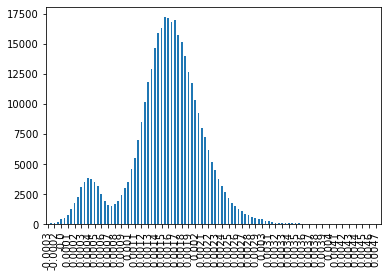

In [130]:
hist_plot = pd.Series({b_i:c_i for c_i, b_i in zip(c, b[:-1])})
hist_plot.plot(kind='bar')
plt.xticks(range(len(hist_plot))[::2], list(map(lambda x: round(x, 4), hist_plot.index))[::2]);

In [133]:
(inner_join_df
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])
 ['dot_product'].idxmax()
 .head(3)
)

entry_id_x  version_x  sent_idx_x  sent_idx_y  word_idx_x  token_x   
547989      0          0           0           0           WASHINGTON       0
                                               1           —              608
                                               2           Weapons       1216
Name: dot_product, dtype: int64

In [134]:
max_words = (inner_join_df
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()]
 [des_col_list]
 .groupby([
     'entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'
 ])['dot_product']
 .mean()
 .reset_index()
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
 .sort_values('sent_idx_x')
#  .loc[lambda df: df['sent_idx_x'] != df['sent_idx_y']]
)

In [ ]:
#                  CONCAT(word_emb.entry_id, '-', 
#                         word_emb.version, '-',
#                         word_emb_2.version, '-',
#                         word_emb.sent_idx, '-',
#                         word_emb_2.sent_idx, '-',
#                         word_emb.word_idx, '-',
#                         word_emb_2.word_idx, '-',
#                         word_emb.token, '-'
#                         )                                                            AS partition_key,